In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy as scp
import os

plt.style.use('fast')
#plt.rc('text', usetex=True)
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 30}

plt.rc('font', **font)

In [114]:
filepaths = ['..\Widerstand']
measurements = {}
for filepath in filepaths:
    for name in os.listdir(filepath):
        if name.endswith('.xlsx'):
            df = pd.read_excel(filepath + '\\' + name)
            arr = np.transpose(df.to_numpy())
            measurements[name.split('.')[0]] = arr

In [115]:
r_avgs = {}
cutoffs = {}

for name in measurements:
    time = measurements[name][-1]
    resistance = measurements[name][-2]
    voltage = measurements[name][-3]
    current = measurements[name][-4]
    temperature = measurements[name][0]

    res_avg = 0
    if temperature[0] > 20:
        for i in range(len(temperature)):
            #print(temperature[i])
            if temperature[i] < 20:
                res_avg = np.median(resistance[i:])
                cutoffs[name] = i
                break
    else:
        for i in range(len(temperature)):
            #print(temperature[i])
            if temperature[i] > 20:
                res_avg = np.median(resistance[:i])
                cutoffs[name] = i
                break
    r_avgs[name] = res_avg
print('min: ',min(r_avgs),r_avgs[min(r_avgs)], ' max: ', max(r_avgs) ,r_avgs[max(r_avgs)])

min:  probe2_dw 0.00039105091  max:  probe4_up 0.002641418165


In [116]:
cutoffs

{'probe2_dw': 3242,
 'probe2_up': 208,
 'probe3_dw': 3300,
 'probe3_up': 209,
 'probe4_dw': 3339,
 'probe4_up': 214}

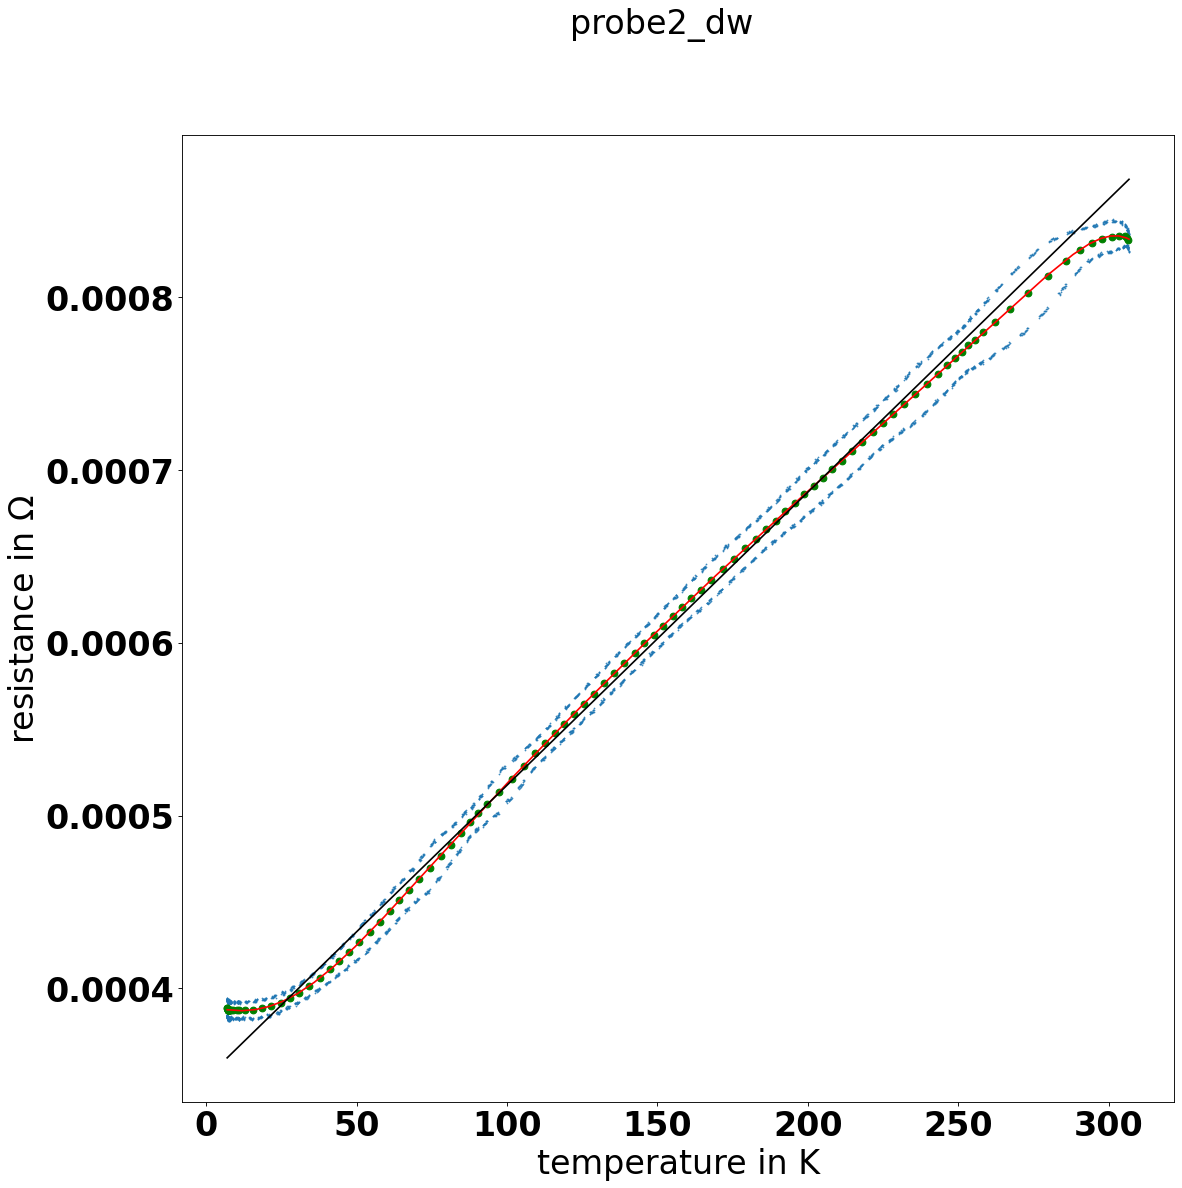

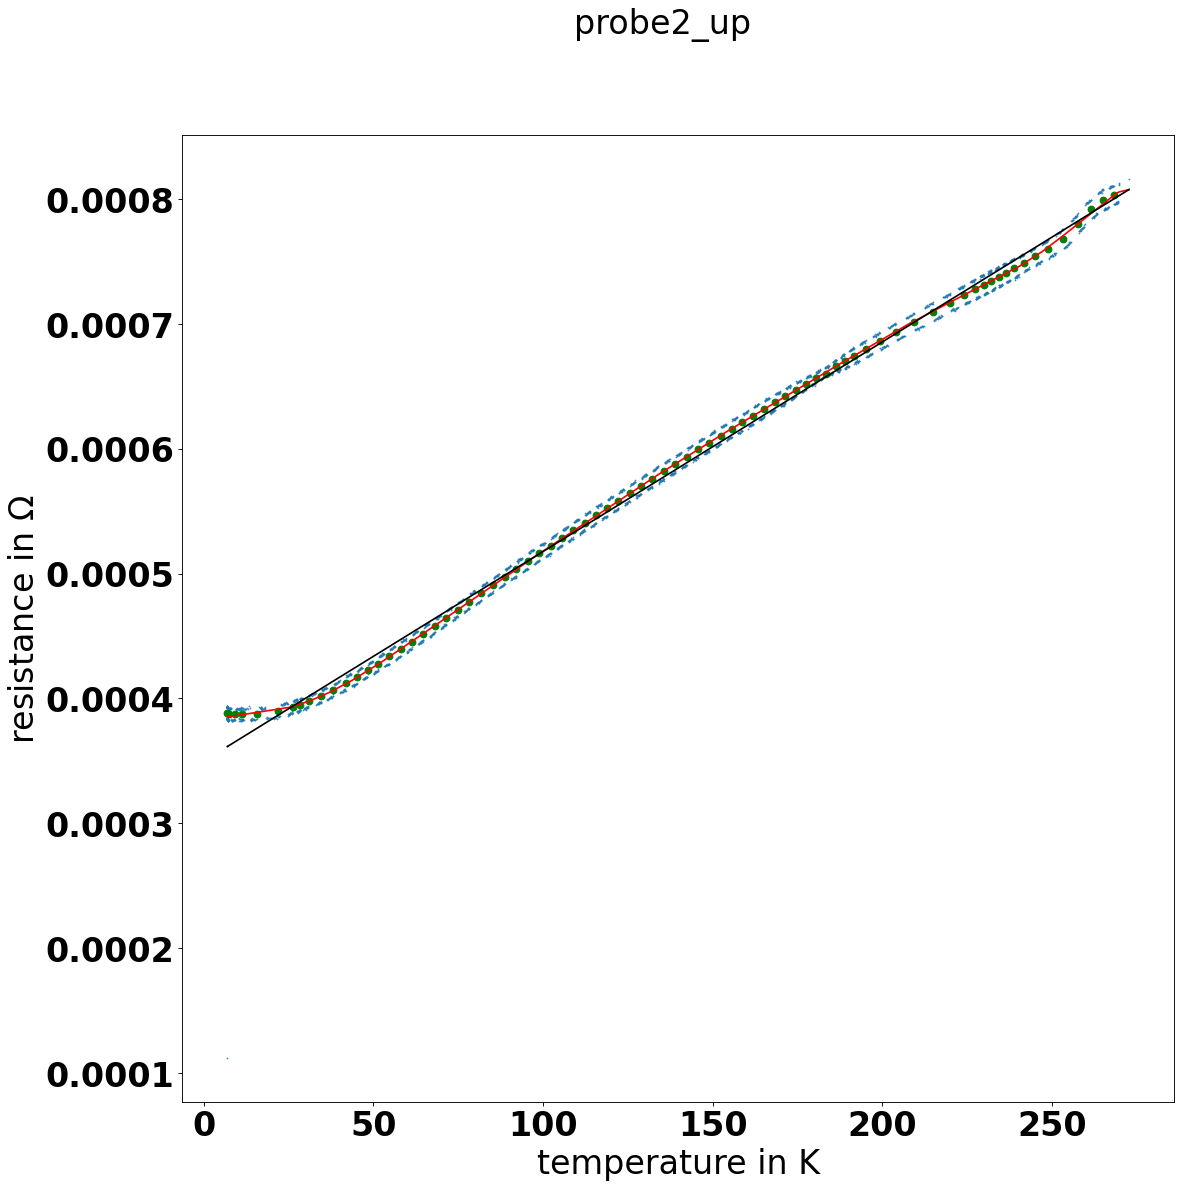

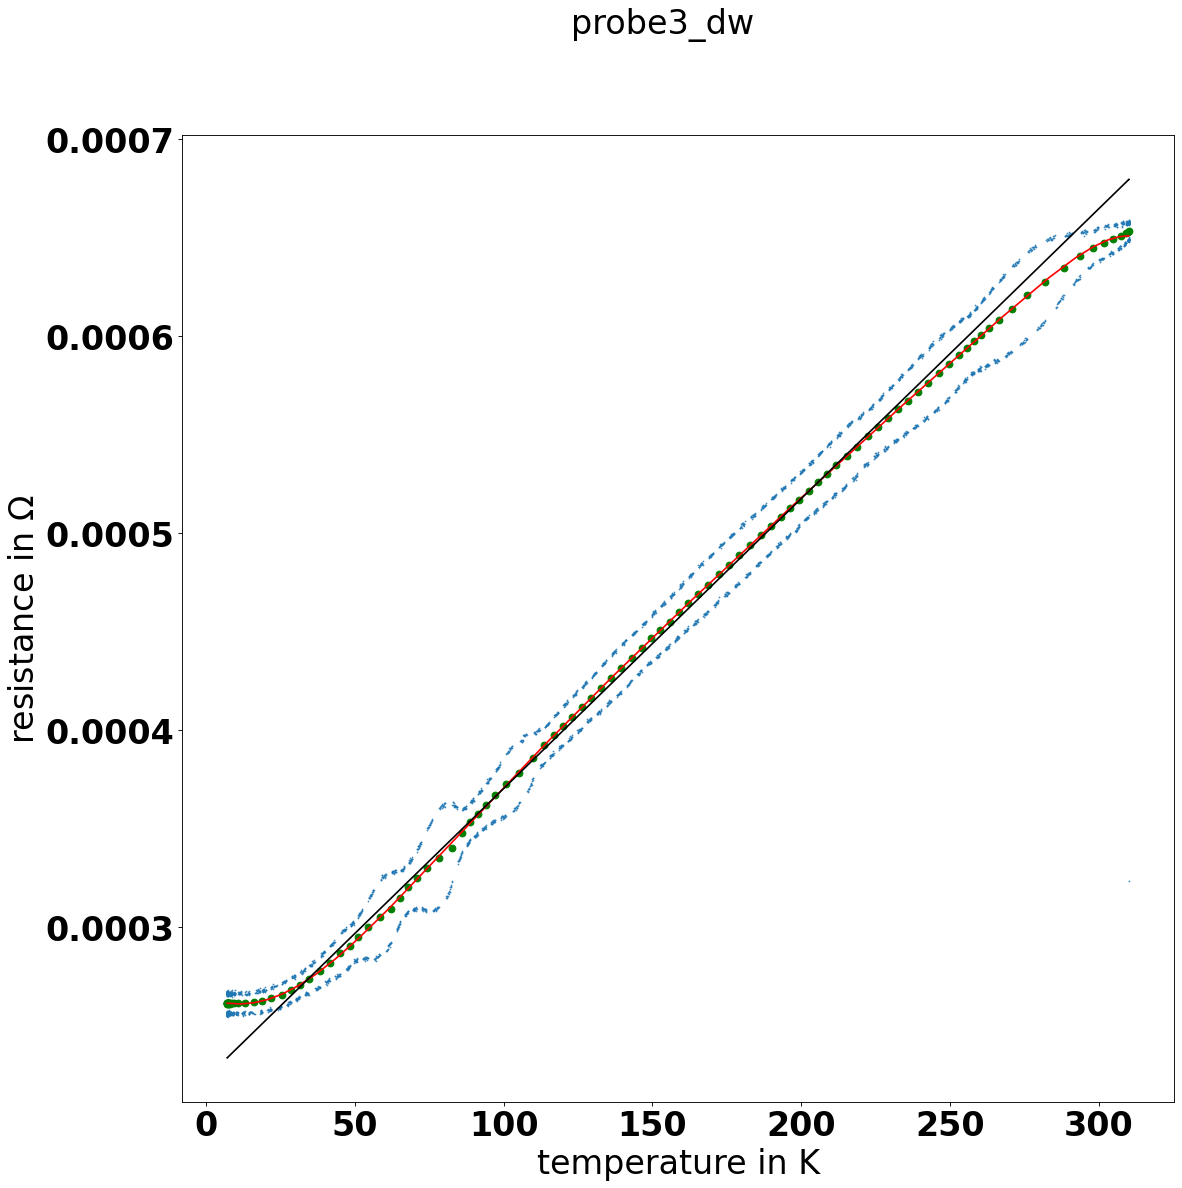

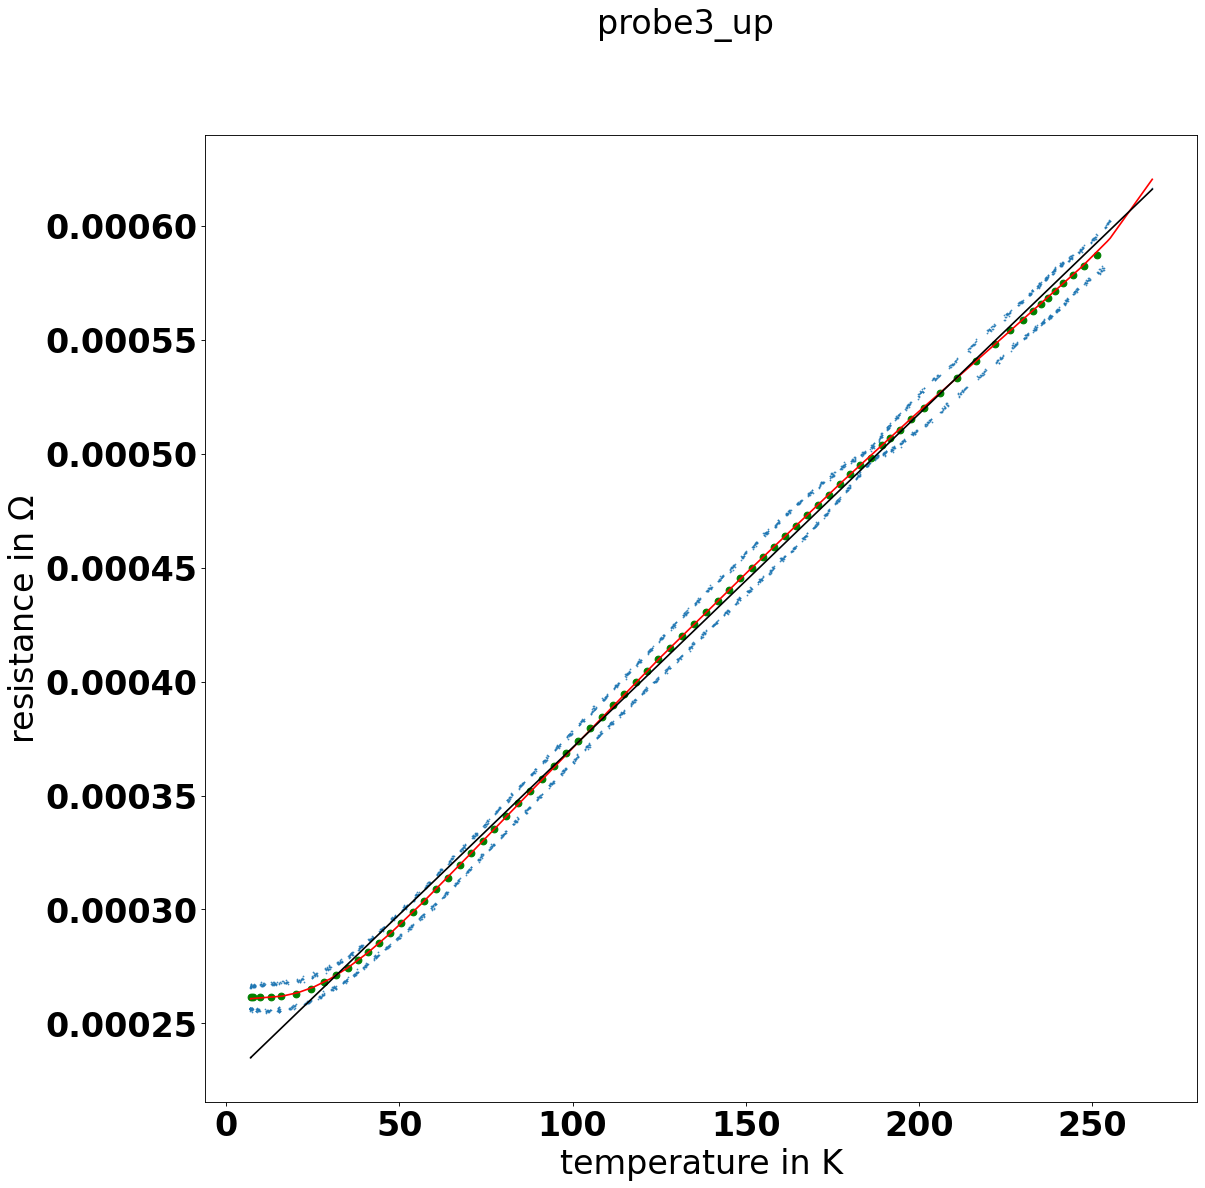

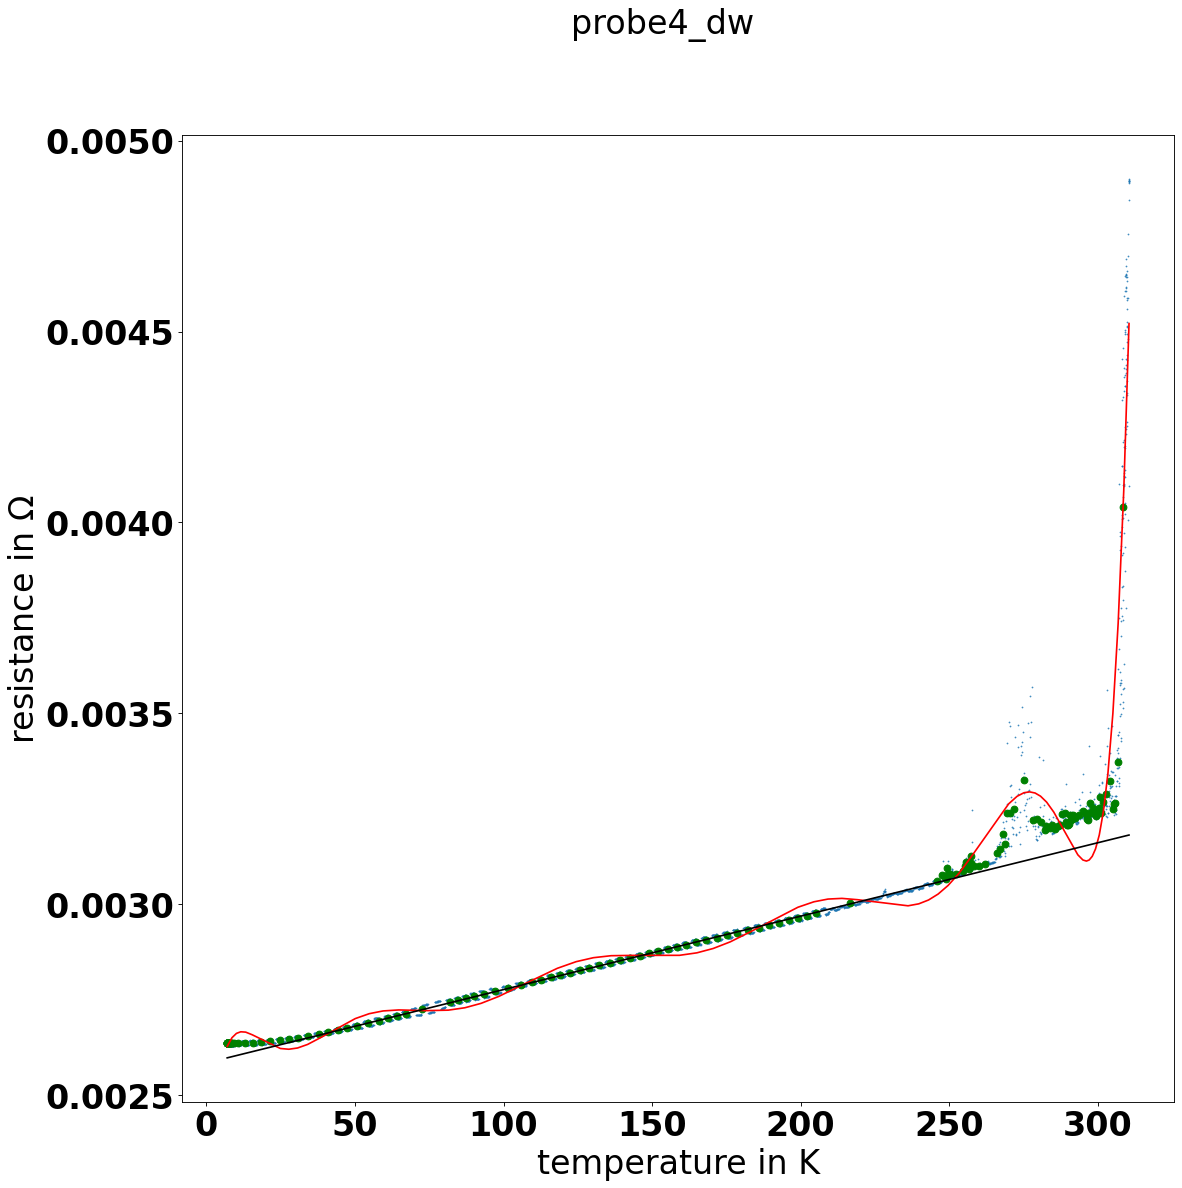

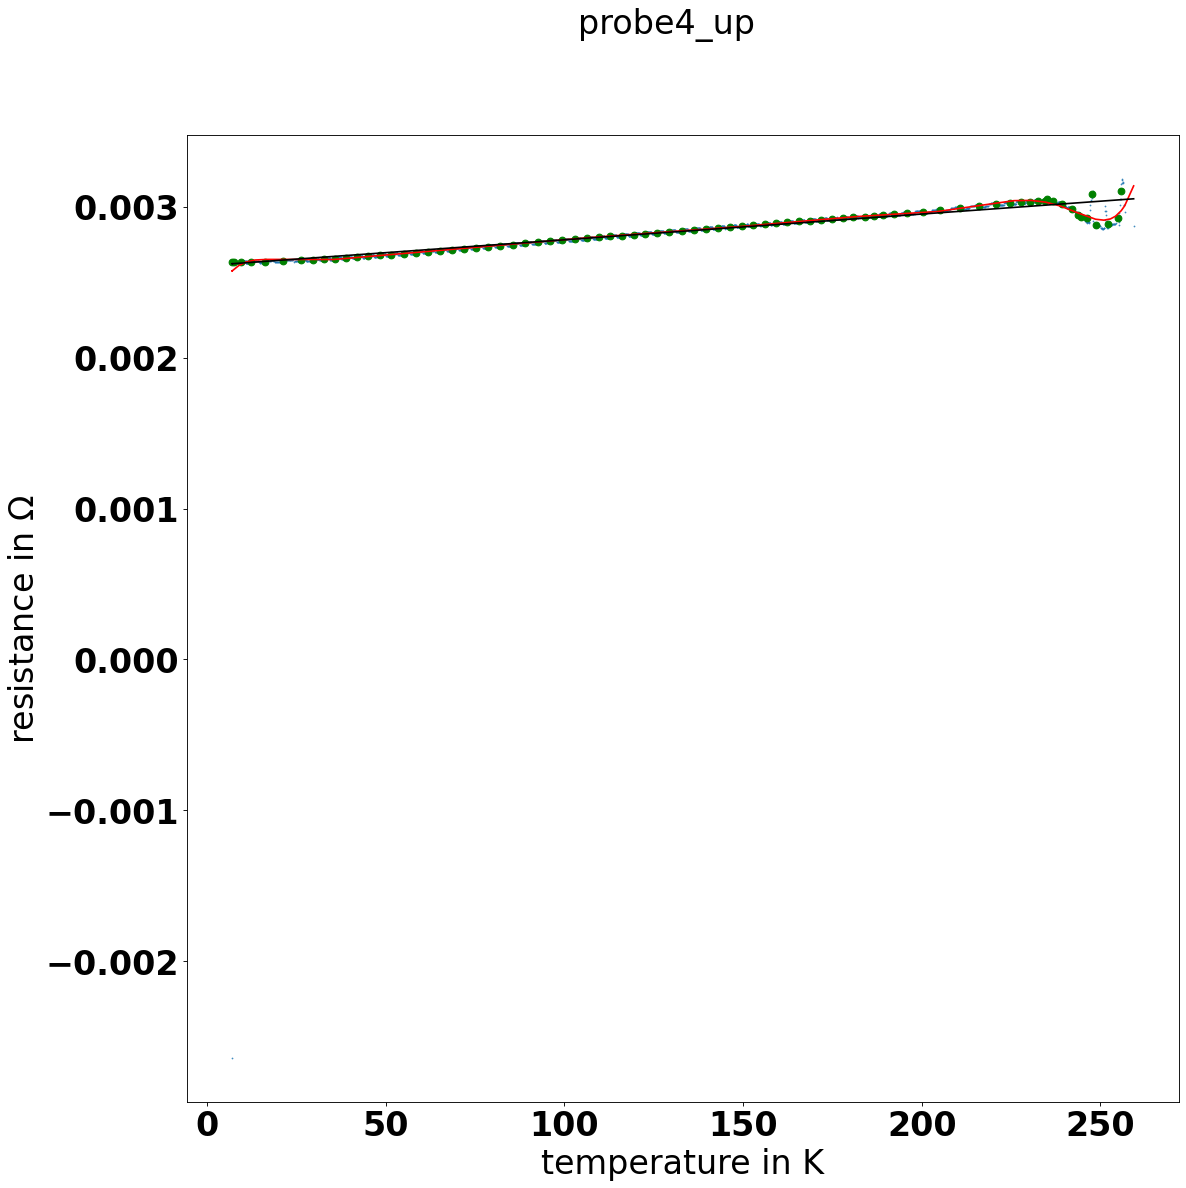

In [118]:
def f(x,a,b,c,d,e,f,g,h,i,j,k,l):
    return a + b*x + c*x**2 + d*x**3 + e*x**4 + f*x**5 + g*x**6 + h*x**7 + i*x**8 + j*x**9 + k*x**10 + l*x**11

def f2(x,a):
    return a



def res_elements(res,temp,name):
    er = []
    eT = []

    thresh = {'probe2_dw_min':0.7e-5,'probe2_dw_max':4.5e-5,
            'probe2_up_min':0.7e-5,'probe2_up_max':2e-5,
            'probe3_dw_min':0.7e-5,'probe3_dw_max':7e-5,
            'probe3_up_min':0.5e-5,'probe3_up_max':2e-5,
            'probe4_dw_min':0.7e-5,'probe4_dw_max':2e-5,
            'probe4_up_min':0.7e-5,'probe4_up_max':2e-5,}
    thresh_min = thresh[name+"_min"]
    thresh_max = thresh[name+"_max"]
    start = 0 
    stop = 0
    sold = 0

    dx = []
    for i in range(len(res)-1):
        dx.append(res[i]-res[i+1])
    
    for i in range(len(dx)):
       # print(abs(dx[i]))
        if abs(dx[i]) > thresh_min and abs(dx[i]) < thresh_max:
            if start == sold:
                start = i
            else:
                stop = i
                #print(start,stop)
                er.append(np.average(res[start:stop]))
                eT.append(np.average(temp[start:stop]))
                sold = start
                start = i
    
    r = []
    t = []
    for i in range(0,len(er)-1,2):
        r.append(1/2*(er[i]+er[i+1]))
        t.append(1/2*(eT[i]+eT[i+1]))
    
    return r,t


for name in measurements:
    time = measurements[name][-1]
    resistance = measurements[name][-2]
    voltage = measurements[name][-3]
    current = measurements[name][-4]
    temperature = measurements[name][0]

    temp = []
    rtemp = []
    if temperature[0] > temperature[-1]:
        for i in range(len(temperature)):
            temp.append(temperature[-(i+1)])
            rtemp.append(resistance[-(i+1)])
        temperature = temp
        resistance = rtemp

    popt, pcov = opt.curve_fit(f,temperature,resistance)

    fig = plt.figure(figsize=(16,16),dpi=80)
    fig.tight_layout(pad=0.5, w_pad=3.5, h_pad=3.5)
    fig.suptitle(name,size=30)
    
    #ax = fig.add_subplot(321)
    #ax.scatter(time,temperature,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel="temperature in K")

    #ax = fig.add_subplot(322)
    #ax.scatter(time,current,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel="current in A")

    #ax = fig.add_subplot(323)
    #ax.scatter(time,voltage,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel="voltage in V")

    #ax = fig.add_subplot(324)
    #ax.scatter(time,resistance,marker=".",s=1)
    #ax.set(xlabel="time in s",ylabel=r"resistance in $\Omega$")

    ax = fig.add_subplot(111)
    ax.scatter(temperature,resistance,marker=".",s=1)
    ax.set(xlabel="temperature in K",ylabel=r"resistance in $\Omega$")


    r,t = res_elements(resistance,temperature,name)
    index_l = 0
    index_h = 0
    for i in range(len(temperature)):
        if abs(temperature[i] - 50) < 1.5:
            #print("test",name,t[i])
            index_l = i
    for i in range(len(temperature)):
        if abs(temperature[i] - 250) < 4.5:
            #print("test",name,t[i])
            index_h = i

    ax.plot(temperature,[f(x,*popt) for x in temperature],color="red",label="fit")
    def f3(x,a,b):
        return a + x*b
    
    popt, pcov = opt.curve_fit(f3,temperature[index_l:index_h],resistance[index_l:index_h])
    ax.plot(temperature,[f3(x,*popt) for x in temperature],color="black",label="fit")
    #ax.plot(t[:index],[f2(x,min(r)) for x in t[:index]],color="black",label="fit")
    ax.scatter(t,r,color="green",label="avg")

    plt.savefig(name)
    #break
